## workflow of ReAct Agent

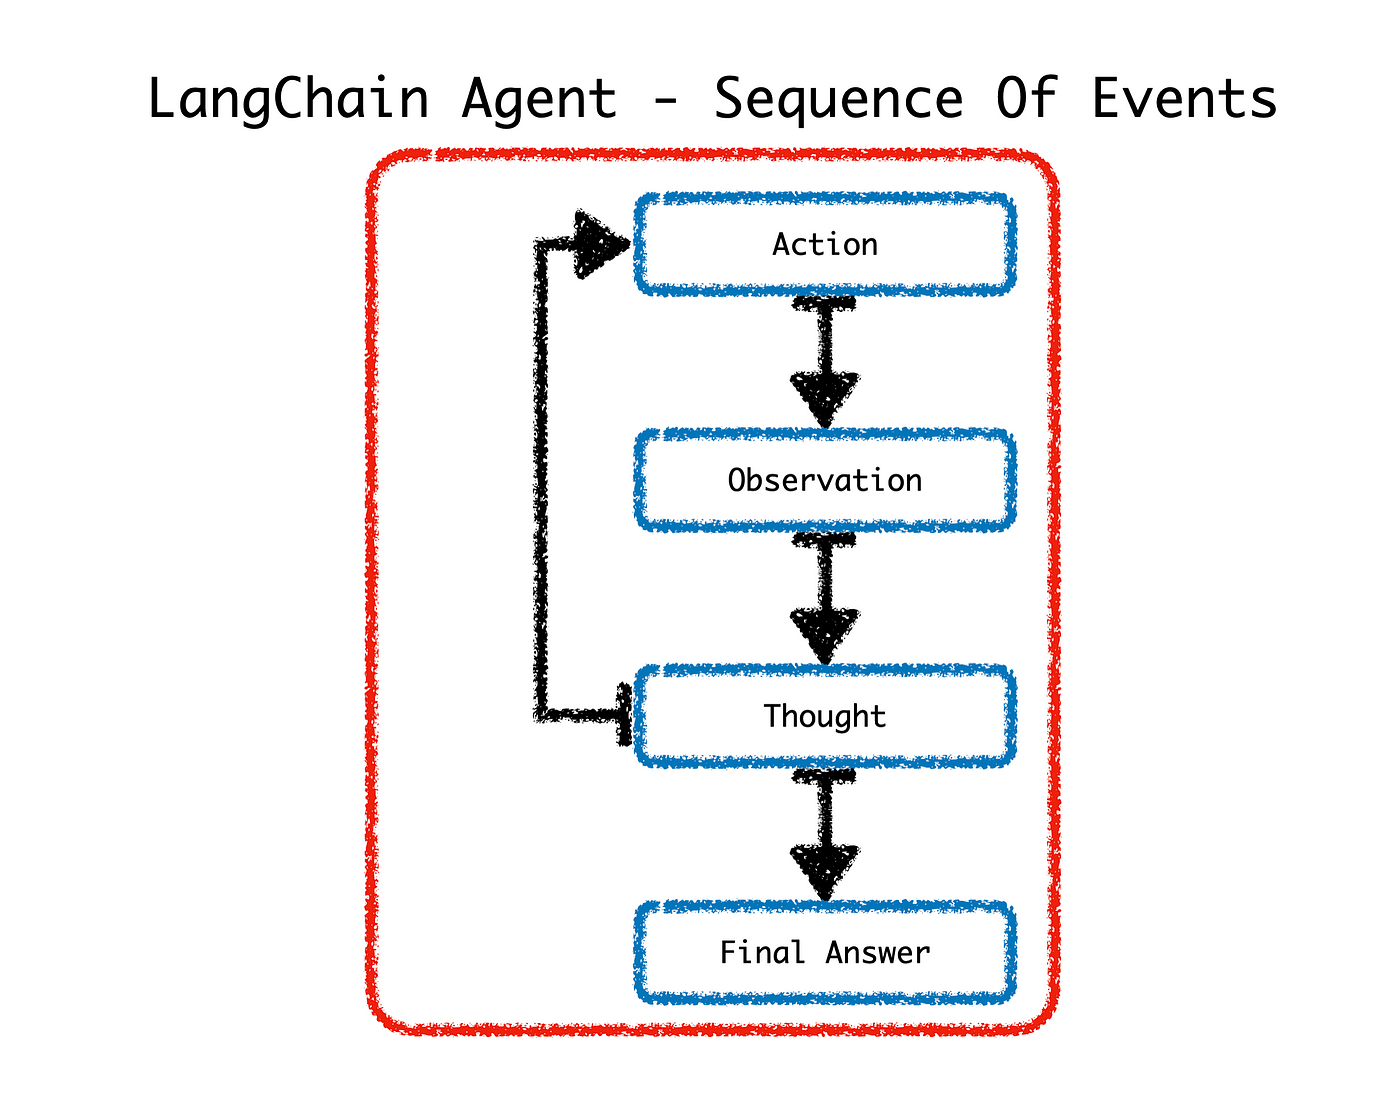

In [15]:
import os
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated, TypedDict
import operator

In [11]:
# Configuring Gemini LLM

from langchain_google_genai import ChatGoogleGenerativeAI

llm= ChatGoogleGenerativeAI(model='gemini-1.5-pro')

response= llm.invoke([HumanMessage(content='Hi who are you ?')])
response.pretty_print()

================================== Ai Message ==================================

I am a large language model, trained by Google.  I'm a computer program designed to understand and generate human-like text.  I don't have a name or a physical body.  I exist only as code and data on Google's servers.

I can answer your questions, translate languages, write different kinds of creative content, and summarize text for you.  I'm still under development, but I'm learning new things all the time.


In [61]:
def multiply(a: float, b: float) -> float:
    '''
    Multiplies a and b
    Args:
        a: first int
        b: second int
    '''
    return a*b

def add(a: float, b: float) -> float:
    '''
    Adding a and b
    Args:
        a: first int
        b: second int
    '''
    return a+b

def divide(a: float, b: float) -> float:
    '''
    Divides a and b
    Args:
        a: first int
        b: second int
    '''
    return a/b

In [4]:
search = DuckDuckGoSearchRun()

search.invoke("who is a current president of Russia?")

"Vladimir Putin has formally begun his fifth term as Russia's president in a carefully choreographed inauguration ceremony, in a country he has shaped in his image after first taking office ... President of Russia Vladimir Putin: Citizens of Russia, ladies and gentlemen, friends, In these solemn and crucial moments of assuming the office of the President, I would like to extend my heartfelt gratitude to the citizens of Russia across all regions of our country, as well as those living in the historical territories of Russia who have ... President Vladimir Putin has been sworn in for a new six-year term at a ceremony that was boycotted by the United States and a number of other Western countries because of Russia's war in Ukraine. Vladimir Putin (born October 7, 1952, Leningrad, Russia, U.S.S.R. [now St. Petersburg, Russia]) is a Russian intelligence officer and politician who has served as president (1999-2008 and 2012- ) of Russia and as the country's prime minister (1999 and 2008-12).

In [26]:
# adding the add, multiply, divide and DuckDuckGo into tools

tools= [multiply, add, divide, search]

#Binding the tools with LLM
llm_with_tools= llm.bind_tools(tools)

#Creating the tool_node to use tool as node
tool_node= ToolNode(tools)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [27]:
# System Message (prompt)
system_message= SystemMessage(content= 'you are a helpful assistant tasked to using search and performing arithmetic operations on given inputs')

# creating a function for agents with system message --> SystemMessage, HumanMessage should be passed with []
def reasoner(state: MessagesState):
    response= llm_with_tools.invoke([system_message] + state['messages'])
    return {'messages': [response]}

In [28]:
# Building the ReAct Agent Graph

from langgraph.checkpoint.memory import MemorySaver

workflow= StateGraph(MessagesState)

workflow.add_node('Agent', reasoner)
workflow.add_node('tools', tool_node)

workflow.add_edge(START, 'Agent')
# If the latest message (result) from node Agent is a tool call -> tools_condition routes to tools
# If the latest message (result) from node Agent is a not a tool call -> tools_condition routes to END
workflow.add_conditional_edges('Agent', tools_condition) # Instead of router function we are using tools_condition
workflow.add_edge('tools', 'Agent')

memory= MemorySaver()
ReAct_graph= workflow.compile(checkpointer=memory)

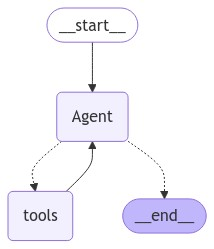

In [29]:
# Visulaizing the ReAct Graph

from IPython.display import display, Image
display(Image(ReAct_graph.get_graph(xray=True).draw_mermaid_png()))

In [30]:
# config is needed to maintain the chat history
config= {'configurable':{'thread_id':'abc123'}}

# passing the input in HumanMessage format
input={'messages':[HumanMessage(content="What is 2 times of Elon Musk age?")]}

response= ReAct_graph.invoke(input, config) 

{'name': 'multiply', 'description': 'Multiplies a and b\nArgs:\n    a: first int\n    b: second int', 'parameters': {'type_': 6, 'description': 'Multiplies a and b\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'add', 'description': 'Adding a and b\nArgs:\n    a: first int\n    b: second int', 'parameters': {'type_': 6, 'description': 'Adding a and b\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required'

In [31]:
for res in response['messages']:
    res.pretty_print()

================================ Human Message =================================

What is 2 times of Elon Musk age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (e58f684f-2434-4e4b-8999-cc713151cb26)
 Call ID: e58f684f-2434-4e4b-8999-cc713151cb26
  Args:
    query: Elon Musk age
================================= Tool Message =================================
Name: duckduckgo_search

#1 Elon Musk on the 2024 Forbes 400. Shop Our Favorite Holiday Deals! PROFILE. Elon Musk. CEO, Tesla. ... Age 53 Source of Wealth Tesla, SpaceX, Self Made Self-Made Score 8 Philanthropy Score 1 Elon Musk is the richest person in the world, a position he held for much of 2022 as well. His fortune rose by $6 billion during December 2023. Bernard Arnault fell to No. 2 richest in early June 2023 and has remained at that rank. He was the richest person in the world for the first five months of 2023. ... Age: 52 Residence: Austin, Texas ... Elon 

In [32]:
input2= {'messages': [HumanMessage(content="What is the result when you add 10 years to the current age of Donald Trump?")]}

response2 =ReAct_graph.invoke(input2, config)

for res in response2['messages']:
    res.pretty_print()

{'name': 'multiply', 'description': 'Multiplies a and b\nArgs:\n    a: first int\n    b: second int', 'parameters': {'type_': 6, 'description': 'Multiplies a and b\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'add', 'description': 'Adding a and b\nArgs:\n    a: first int\n    b: second int', 'parameters': {'type_': 6, 'description': 'Adding a and b\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required'

### Checking chat history

In [ ]:
input3= {'messages': [HumanMessage(content="What number is added with the age of Donald Trump previously?")]}

response3 =ReAct_graph.invoke(input3, config)

for res in response3['messages']:
    res.pretty_print()

{'name': 'multiply', 'description': 'Multiplies a and b\nArgs:\n    a: first int\n    b: second int', 'parameters': {'type_': 6, 'description': 'Multiplies a and b\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'add', 'description': 'Adding a and b\nArgs:\n    a: first int\n    b: second int', 'parameters': {'type_': 6, 'description': 'Adding a and b\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required'

### Finance Bot

In [67]:
import yfinance as yf

def get_stock_price(ticker: str)-> float:
    """This is a tool for getting the price of a stock when passed a ticker symbol
    Args:
        ticker: ticker str
    """
    stock= yf.Ticker(ticker)
    return stock.info['previousClose']

In [68]:
get_stock_price('INFY')

22.74

In [69]:
tools= [multiply, add, divide, search, get_stock_price]

tool_node= ToolNode(tools)

llm_with_tools= llm.bind_tools(tools)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [70]:
def reasoner(state):
    query = state["query"]
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    result = llm_with_tools.invoke([sys_msg] + messages)
    return {"messages":[result]}
    

In [71]:

class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]
     

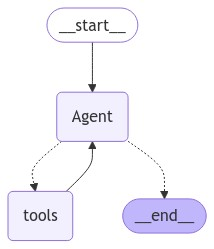

In [72]:
# Building the ReAct Agent Graph

workflow= StateGraph(GraphState)

workflow.add_node('Agent', reasoner)
workflow.add_node('tools', tool_node)

workflow.add_edge(START, 'Agent')
# If the latest message (result) from node Agent is a tool call -> tools_condition routes to tools
# If the latest message (result) from node Agent is a not a tool call -> tools_condition routes to END
workflow.add_conditional_edges('Agent', tools_condition) # Instead of router function we are using tools_condition
workflow.add_edge('tools', 'Agent')

graph= workflow.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [73]:
response = graph.invoke({"query": "What is the stock price of Tesla add 1000?", "messages": []})

for m in response['messages']:
    m.pretty_print()

{'name': 'multiply', 'description': 'Multiplies a and b\nArgs:\n    a: first int\n    b: second int', 'parameters': {'type_': 6, 'description': 'Multiplies a and b\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 2, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 2, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'add', 'description': 'Adding a and b\nArgs:\n    a: first int\n    b: second int', 'parameters': {'type_': 6, 'description': 'Adding a and b\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 2, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required'

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..


{'name': 'multiply', 'description': 'Multiplies a and b\nArgs:\n    a: first int\n    b: second int', 'parameters': {'type_': 6, 'description': 'Multiplies a and b\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 2, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 2, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'add', 'description': 'Adding a and b\nArgs:\n    a: first int\n    b: second int', 'parameters': {'type_': 6, 'description': 'Adding a and b\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 2, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required'